<a href="https://colab.research.google.com/github/samugatu/CIS-IEEE/blob/main/Star_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stellar Classification

Como estudante de física, considero esta atividade muito interessante por sua conexão direta com minha área de estudo. É verdade que, ao pensarmos em físicos, nem sempre as primeiras associações que surgem são com programação, ciência de dados ou Inteligência Artificial. Muitas vezes, a imagem que prevalece é a de um profissional dedicado principalmente a cálculos teóricos e experimentação mais tradicional.

No entanto, a física contemporânea opera de uma maneira distinta, especialmente em seus ramos experimentais, como a física de partículas – onde se destacam o CERN e o LHC – e nos campos observacionais, como a astronomia e a astrofísica, que dependem de dados de grandes telescópios como o Hubble e o James Webb. Todas essas áreas lidam com um volume verdadeiramente expressivo de dados.

Isso significa que os físicos de hoje precisam ser também analistas de dados competentes, combinando essa habilidade com um profundo entendimento de matemática e dos princípios físicos. Essa sinergia é crucial para extrair o máximo de conhecimento das informações coletadas.

Este desafio, portanto, nos oferece uma boa oportunidade de vivenciar um pouco do que significa ser um astrônomo na atualidade, trabalhando diretamente com essa grande quantidade de dados.

capanotebook.png

# Código

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('star_classification.csv')

print(df.head())
print(df.info())

         obj_ID       alpha      delta         u         g         r  \
0  1.237661e+18  135.689107  32.494632  23.87882  22.27530  20.39501   
1  1.237665e+18  144.826101  31.274185  24.77759  22.83188  22.58444   
2  1.237661e+18  142.188790  35.582444  25.26307  22.66389  20.60976   
3  1.237663e+18  338.741038  -0.402828  22.13682  23.77656  21.61162   
4  1.237680e+18  345.282593  21.183866  19.43718  17.58028  16.49747   

          i         z  run_ID  rerun_ID  cam_col  field_ID   spec_obj_ID  \
0  19.16573  18.79371    3606       301        2        79  6.543777e+18   
1  21.16812  21.61427    4518       301        5       119  1.176014e+19   
2  19.34857  18.94827    3606       301        2       120  5.152200e+18   
3  20.50454  19.25010    4192       301        3       214  1.030107e+19   
4  15.97711  15.54461    8102       301        3       137  6.891865e+18   

    class  redshift  plate    MJD  fiber_ID  
0  GALAXY  0.634794   5812  56354       171  
1  GALAXY  0.77913

Olhando as 18 colunas, podemos notar que algumas dessas informações servem para identificação e não algo propiamente util para a classificação.

Colunas com ID's não nos serão util. Além disso alpha e delta são referencias da angulos de observação, cam_col tambem é de identificação.Plate tambem é de identificação  tal como MJD.

Assim as colunas que serão importantes como features serão as restantes e nosso target jsutamente a classificação.

In [ ]:
features = ['u','g','r','i','z','redshift']
target = 'class'

X = df[features].values
y = df[target].values

Vamos transformar a variavel target em números

In [ ]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

class_name = label_encoder.classes_
print(class_name)

['GALAXY' 'QSO' 'STAR']


Dividir em treino e teste seguindo (70/30)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Normalizar

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Converter para os tensores do PyTorch e criar os data loaders com o batch_size = 32:

In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Agora vamos definir a arquitetura:

teremos 1 camada oculta com128 neuronios e uma segunda camada oculta com 64, ambas com a funçao de ativação ReLU. Obviamente teremos uma camada de saida com 3 neuronios.

In [ ]:
class StellarClassifier(nn.Module):
  def __init__(self, input_size, numClasses):
    super(StellarClassifier, self).__init__()
    self.fc1 = nn.Linear(input_size, 128)
    self.relu1 = nn.ReLU()
    self.fc2 = nn.Linear(128, 64)
    self.relu2 = nn.ReLU()
    self.fc3 = nn.Linear(64, numClasses)

  def forward(self, x):
    x = self.fc1(x)
    x = self.relu1(x)
    x = self.fc2(x)
    x = self.relu2(x)
    x = self.fc3(x)
    return x

Vamos instanciar, definir a função de perda e o otimizador. Nesse caso a função de perda será nn.CrossEntropyLoss pois é adequada para problemas de classificação multiclasse e teremos uma taxa de aprendizagem de 0.001:

In [ ]:
input_size = X_train.shape[1]
numClasses = len(np.unique(y))

model = StellarClassifier(input_size, numClasses)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Faremos um treinamento de 25 epochs

In [ ]:
num_epochs = 25
train_losses = []
train_acuracies = []

for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  correct_predictions = 0
  total_predictions = 0

  for inputs, labels in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()*inputs.size(0)
    _, predicted = torch.max(outputs.data, 1)
    total_predictions += labels.size(0)
    correct_predictions += (predicted == labels).sum().item()

  epoch_loss = running_loss / len(train_loader.dataset)
  epoch_accuracy = correct_predictions / total_predictions

  train_losses.append(epoch_loss)
  train_acuracies.append(epoch_accuracy)

  print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

Epoch 1/25, Loss: 0.1818, Accuracy: 0.9410
Epoch 2/25, Loss: 0.1223, Accuracy: 0.9621
Epoch 3/25, Loss: 0.1135, Accuracy: 0.9650
Epoch 4/25, Loss: 0.1098, Accuracy: 0.9660
Epoch 5/25, Loss: 0.1065, Accuracy: 0.9669
Epoch 6/25, Loss: 0.1030, Accuracy: 0.9686
Epoch 7/25, Loss: 0.1011, Accuracy: 0.9689
Epoch 8/25, Loss: 0.1007, Accuracy: 0.9691
Epoch 9/25, Loss: 0.0985, Accuracy: 0.9704
Epoch 10/25, Loss: 0.0975, Accuracy: 0.9704
Epoch 11/25, Loss: 0.0969, Accuracy: 0.9705
Epoch 12/25, Loss: 0.0956, Accuracy: 0.9710
Epoch 13/25, Loss: 0.0947, Accuracy: 0.9711
Epoch 14/25, Loss: 0.0935, Accuracy: 0.9715
Epoch 15/25, Loss: 0.0940, Accuracy: 0.9718
Epoch 16/25, Loss: 0.0924, Accuracy: 0.9721
Epoch 17/25, Loss: 0.0922, Accuracy: 0.9719
Epoch 18/25, Loss: 0.0909, Accuracy: 0.9724
Epoch 19/25, Loss: 0.0908, Accuracy: 0.9722
Epoch 20/25, Loss: 0.0906, Accuracy: 0.9722
Epoch 21/25, Loss: 0.0913, Accuracy: 0.9719
Epoch 22/25, Loss: 0.0907, Accuracy: 0.9722
Epoch 23/25, Loss: 0.0894, Accuracy: 0.97

Agora vamos avaliar este modelo:

In [ ]:
model.eval()
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
  for inputs, labels in test_loader:
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total_predictions += labels.size(0)
    correct_predictions += (predicted == labels).sum().item()

test_accuracy = correct_predictions / total_predictions
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.9726


Neste primeiro modelo tivemos uma acuracia de **97.23%**

com:
batch_size = 32

*   treino teste = 70/30
*   batch_size = 32
*   2 camdas ocultas (128 e 64)
*   função de ativação ReLu
*   Learning Rate 0.001
*   função de perda nn.CrossEntropy()
*   Otimizador Adam




# Diferentes configurações de Redes

Vamos testar agora diferentes niveis de profundidades e larguras da nossa rede neural. Para isso vamos criar a classe DynamicStarClassifier, onde receberá como argumento hidden_layer_config que será uma lista em que a quantidade de elementos é a profundidade e o número é a quantidade de neuronios. Por exemplos na nossa rede neural atual a hidden_layer_config é [128,64], a primeira camada oculta com 128 neuronios e a segunda com 64.

As camadas de entrada e saída, Linear e Dropout são ajustadas automaticamente tal como a função de ativação ReLu entre as camadas ocultas.

In [ ]:
class DynamicStarClassifier(nn.Module):
  def __init__(self, input_size, numClasses,hidden_layer_config):

    super(DynamicStarClassifier, self).__init__()
    self.layers = []
    current_input_size = input_size

    for num_neurons in hidden_layer_config:
      self.layers.append(nn.Linear(current_input_size, num_neurons))
      self.layers.append(nn.ReLU())
      current_input_size = num_neurons

    self.layers.append(nn.Linear(current_input_size, numClasses))

    self.network = nn.Sequential(*self.layers)

  def forward(self, x):
    return self.network(x)

Agora o treinamento, também dinâmico:

In [ ]:
def train_dynamic_model(config_name, criterion, optimizer, model, train_loader, num_epochs=25):
  print(f"Training model with config: {config_name}")

  train_losses = []
  train_accuracies = []

  for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    for inputs, labels in train_loader:
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()*inputs.size(0)
      _, predicted = torch.max(outputs.data, 1)
      total_predictions += labels.size(0)
      correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct_predictions / total_predictions

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

  return train_losses, train_accuracies

Vamos definir as seguinte configurações de rede:

In [ ]:
network_configs = {
    "config1":[32],
    "config2":[64],
    "config3":[128],
    "config4":[32,32],
    "config5":[64,64],
    "config6":[128,128],
    "config7":[32,64],
    "config8":[32,128],
    "config9":[64,128],
    "config10":[128,64],
    "config11":[64,32],
    "config12":[128,32],
    "config13":[32,32,32],
    "config14":[64,64,64],
    "config15":[128,128,128],
    "config16":[32,64,128],
    "config17":[128,64,32],
    "config18":[32,64,32],
    "config19":[64,128,64],
    "config20":[32,128,32]
}


Vamos agora rodar e tentar chegar nos resultados:

In [ ]:
result ={}
input_size = X_train.shape[1]
numClasses = len(np.unique(y))

for config_name, hidden_layer_config in network_configs.items():
  print(f"Training model with config: {config_name}")

  model = DynamicStarClassifier(input_size, numClasses, hidden_layer_config= hidden_layer_config)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  train_losses, train_accuracies = train_dynamic_model(config_name, criterion, optimizer, model, train_loader)
  result[config_name] = {"accuracy": train_accuracies[-1], "loss": train_losses[-1], "Layers": hidden_layer_config}


  model.eval()
  correct_predictions = 0
  total_predictions = 0
  with torch.no_grad():
      for inputs, labels in test_loader:
          outputs = model(inputs)
          _, predicted = torch.max(outputs.data, 1)
          total_predictions += labels.size(0)
          correct_predictions += (predicted == labels).sum().item()
  test_accuracy = correct_predictions / total_predictions
  result[config_name]["test_accuracy"] = test_accuracy
  print(f'Test Accuracy for {config_name}: {test_accuracy:.4f}')

Training model with config: config1
Training model with config: config1
Epoch 1/25, Loss: 0.3470, Accuracy: 0.8739
Epoch 2/25, Loss: 0.1790, Accuracy: 0.9484
Epoch 3/25, Loss: 0.1500, Accuracy: 0.9576
Epoch 4/25, Loss: 0.1370, Accuracy: 0.9612
Epoch 5/25, Loss: 0.1291, Accuracy: 0.9627
Epoch 6/25, Loss: 0.1239, Accuracy: 0.9641
Epoch 7/25, Loss: 0.1196, Accuracy: 0.9652
Epoch 8/25, Loss: 0.1167, Accuracy: 0.9656
Epoch 9/25, Loss: 0.1146, Accuracy: 0.9665
Epoch 10/25, Loss: 0.1123, Accuracy: 0.9674
Epoch 11/25, Loss: 0.1110, Accuracy: 0.9674
Epoch 12/25, Loss: 0.1094, Accuracy: 0.9679
Epoch 13/25, Loss: 0.1083, Accuracy: 0.9678
Epoch 14/25, Loss: 0.1076, Accuracy: 0.9686
Epoch 15/25, Loss: 0.1066, Accuracy: 0.9681
Epoch 16/25, Loss: 0.1058, Accuracy: 0.9690
Epoch 17/25, Loss: 0.1050, Accuracy: 0.9690
Epoch 18/25, Loss: 0.1043, Accuracy: 0.9692
Epoch 19/25, Loss: 0.1040, Accuracy: 0.9689
Epoch 20/25, Loss: 0.1030, Accuracy: 0.9695
Epoch 21/25, Loss: 0.1026, Accuracy: 0.9696
Epoch 22/25, 

In [ ]:
print("Resultados Finais")

for config_name, metrics in result.items():
  print(f"{config_name}:Accuracy= {metrics['accuracy']:.4f}")

Resultados Finais
config1:Accuracy= 0.9695
config2:Accuracy= 0.9705
config3:Accuracy= 0.9708
config4:Accuracy= 0.9711
config5:Accuracy= 0.9719
config6:Accuracy= 0.9729
config7:Accuracy= 0.9712
config8:Accuracy= 0.9718
config9:Accuracy= 0.9724
config10:Accuracy= 0.9728
config11:Accuracy= 0.9720
config12:Accuracy= 0.9725
config13:Accuracy= 0.9718
config14:Accuracy= 0.9721
config15:Accuracy= 0.9733
config16:Accuracy= 0.9724
config17:Accuracy= 0.9725
config18:Accuracy= 0.9720
config19:Accuracy= 0.9725
config20:Accuracy= 0.9723


Bom, tivemos 20 configurações das mais diverisadas possiveis, podemos notar que exceto a primeira, todas as outras estão enentre 0.97 e 0.98.

Temos o destaque para a configuração 15 com 0.9737, config 6 com 0.9733 que tiveram as maiores acurácias.

Lembrando que a config 15 são 3 camadas ocultas de 128 neurônios.

E config 6 são 2 camadas com 128 neuônios.

Nesse trabalho não foi calculado o tempo de execução, que também pode ser uma métrica para melhor escolha de configuração. Então consideraremo a melhor configuração , 3 camadas de 128 neurônios.

# Variando Batch_size

Com a mesma idéia da etapa anterior faremos uam variação no batch_size para analisar a acurácia de cada configuração.

In [ ]:
fixed_hidden_layer_config = [128, 128,128]
input_size = X_train.shape[1]
num_classes = len(np.unique(y))

class DynamicStarClassifier(nn.Module):
    def __init__(self, input_size, num_classes, hidden_layer_config):
        super(DynamicStarClassifier, self).__init__()
        self.layers = []
        current_input_size = input_size

        for num_neurons in hidden_layer_config:
            self.layers.append(nn.Linear(current_input_size, num_neurons))
            self.layers.append(nn.ReLU())
            current_input_size = num_neurons

        self.layers.append(nn.Linear(current_input_size, num_classes))
        self.network = nn.Sequential(*self.layers)
    def forward(self, x):
        return self.network(x)

Função de treino e avaliação adaptada para a nossa configuração:

In [ ]:
def train_and_evaluate_batch_size(model, train_loader,criterion,optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    return running_loss / len(train_loader.dataset), correct_predictions / total_predictions, correct_test / total_test



Definindo os tamanhos das batchs a serem testadas:

In [ ]:
batch_sizes = [16, 32, 64, 128, 512]
batch_sizes_results = {}
learning_rate = 0.001

In [ ]:
for bs in batch_sizes:
  print(f"Training batch size: {bs}")
  train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

  model = DynamicStarClassifier(input_size, num_classes, fixed_hidden_layer_config)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  train_loss, train_accuracy, test_accuracy = train_and_evaluate_batch_size(model, train_loader,criterion,optimizer)
  batch_sizes_results[bs] = (train_loss, train_accuracy, test_accuracy)


  print(f'Test Accuracy: {test_accuracy:.4f}')

Training batch size: 16
Test Accuracy: 0.9722
Training batch size: 32
Test Accuracy: 0.9713
Training batch size: 64
Test Accuracy: 0.9703
Training batch size: 128
Test Accuracy: 0.9699
Training batch size: 512
Test Accuracy: 0.9705


Podemos notar uma diferença mínima, mas o nosso melhor batch size foi de **128**, com acurácia de **0.9724**

# Variando Learning Rate

Vamos variar da mesma forma que foi varaiado o batch_size

In [ ]:
learning_rates = [0.01, 0.005, 0.001, 0.0005 , 0.0001]
learning_rates_results = {}

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

for lr in learning_rates:
  print(f"Training learning rate: {lr}")
  model = DynamicStarClassifier(input_size, num_classes, fixed_hidden_layer_config)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=lr)

  train_loss, train_accuracy, test_accuracy = train_and_evaluate_batch_size(model, train_loader,criterion,optimizer)
  learning_rates_results[lr] = (train_loss, train_accuracy, test_accuracy)

  print(f'Test Accuracy: {test_accuracy:.4f}')

Training learning rate: 0.01
Test Accuracy: 0.9707
Training learning rate: 0.005
Test Accuracy: 0.9252
Training learning rate: 0.001
Test Accuracy: 0.9663
Training learning rate: 0.0005
Test Accuracy: 0.9723
Training learning rate: 0.0001
Test Accuracy: 0.9703


Vamos analisar tambem a função perda:

In [ ]:
def train_and_collect_histort(model, train_loader,criterion,optimizer, num_epochs=25):
  history = {
      "train_loss": [],
      "train_accuracy": [],
      "Loss": [],
      "Accuracy": []
  }
  for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    for inputs, labels in train_loader:
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_train_loss += loss.item() * inputs.size(0)
      _, predicted = torch.max(outputs.data, 1)
      total_predictions += labels.size(0)
      correct_predictions += (predicted == labels).sum().item()

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    epoch_train_accuracy = correct_predictions / total_predictions

    history["train_loss"].append(epoch_train_loss)
    history["train_accuracy"].append(epoch_train_accuracy)

    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
      for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_accuracy = correct_predictions / total_predictions
    history["Loss"].append(epoch_loss)
    history["Accuracy"].append(epoch_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

  return history

learning_rates = [0.01, 0.005, 0.001, 0.0005 , 0.0001]
learning_rates_histories = {}

for lr in learning_rates:
  print(f"Training learning rate: {lr}")

  model= DynamicStarClassifier(input_size, num_classes, fixed_hidden_layer_config)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=lr)

  history = train_and_collect_histort(model, train_loader,criterion,optimizer)
  learning_rates_histories[lr] = history

Training learning rate: 0.01
Epoch 1/25, Loss: 0.2648, Accuracy: 0.9258
Epoch 2/25, Loss: 0.1216, Accuracy: 0.9635
Epoch 3/25, Loss: 0.1859, Accuracy: 0.9406
Epoch 4/25, Loss: 0.2324, Accuracy: 0.9645
Epoch 5/25, Loss: 0.1980, Accuracy: 0.9371
Epoch 6/25, Loss: 0.1834, Accuracy: 0.9650
Epoch 7/25, Loss: 0.1077, Accuracy: 0.9669
Epoch 8/25, Loss: 0.1133, Accuracy: 0.9648
Epoch 9/25, Loss: 0.1015, Accuracy: 0.9687
Epoch 10/25, Loss: 0.1007, Accuracy: 0.9699
Epoch 11/25, Loss: 0.1163, Accuracy: 0.9618
Epoch 12/25, Loss: 0.1130, Accuracy: 0.9633
Epoch 13/25, Loss: 0.1038, Accuracy: 0.9686
Epoch 14/25, Loss: 0.1073, Accuracy: 0.9659
Epoch 15/25, Loss: 0.1524, Accuracy: 0.9711
Epoch 16/25, Loss: 0.3383, Accuracy: 0.9590
Epoch 17/25, Loss: 0.1238, Accuracy: 0.9715
Epoch 18/25, Loss: 0.0991, Accuracy: 0.9705
Epoch 19/25, Loss: 0.1004, Accuracy: 0.9690
Epoch 20/25, Loss: 0.1042, Accuracy: 0.9679
Epoch 21/25, Loss: 0.1028, Accuracy: 0.9705
Epoch 22/25, Loss: 0.1017, Accuracy: 0.9666
Epoch 23/25,

Vamos vizualisar estes resultados:

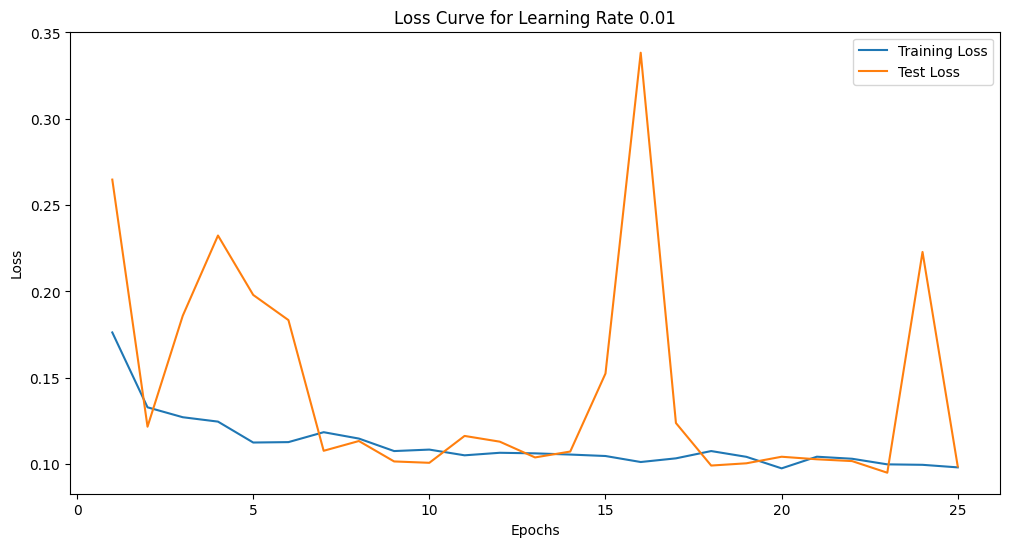

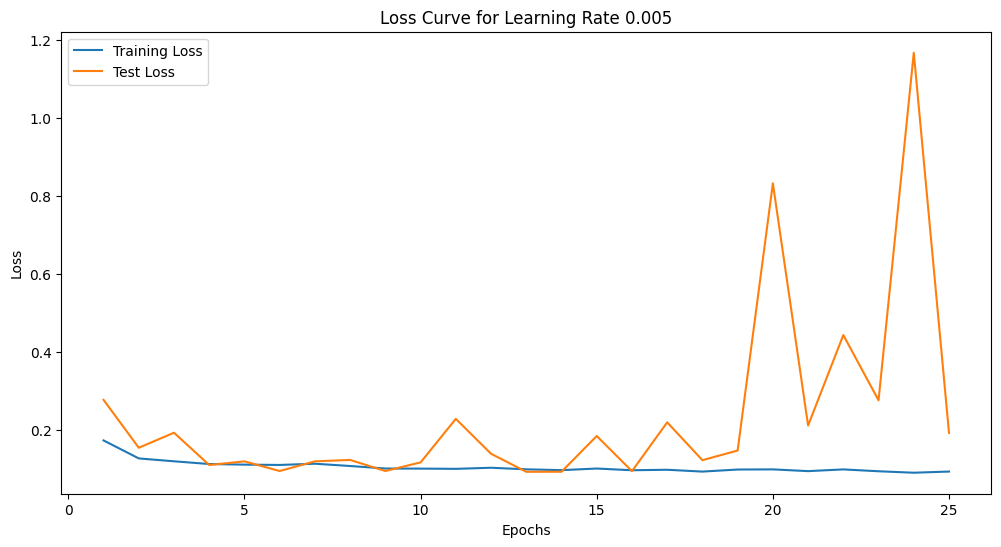

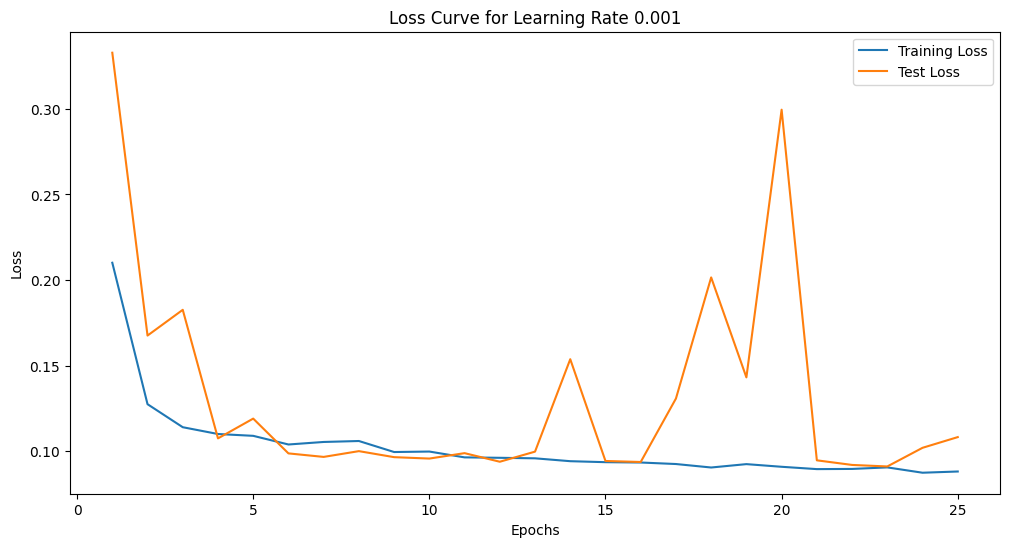

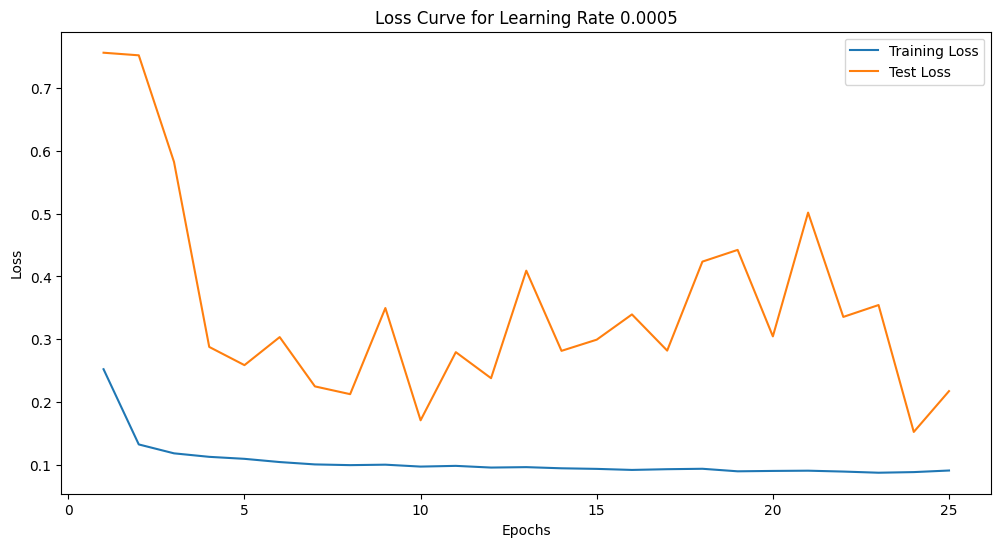

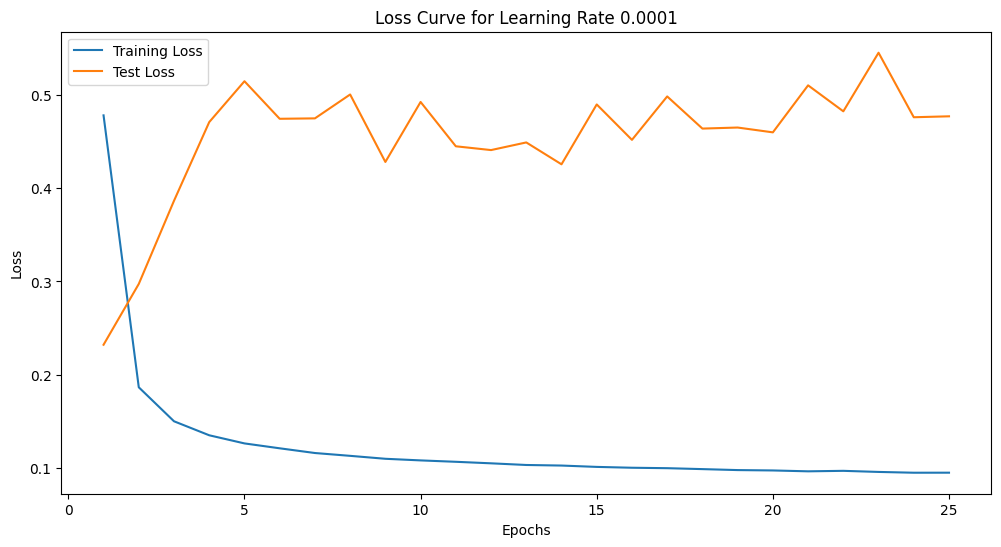

In [ ]:
def plot_loss_curver(lr_value,history_data,num_epochs):
  epochs_range= range(1,num_epochs+1)
  plt.figure(figsize=(12,6))
  plt.plot(epochs_range, history_data["train_loss"], label="Training Loss")
  plt.plot(epochs_range, history_data["Loss"], label="Test Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title(f"Loss Curve for Learning Rate {lr_value}")
  plt.legend()
  plt.show()

for lr_val, history_data in learning_rates_histories.items():
  plot_loss_curver(lr_val,history_data,25)

Agora vamos fazer um gráfico de comparação entre a perda do treino e do test:

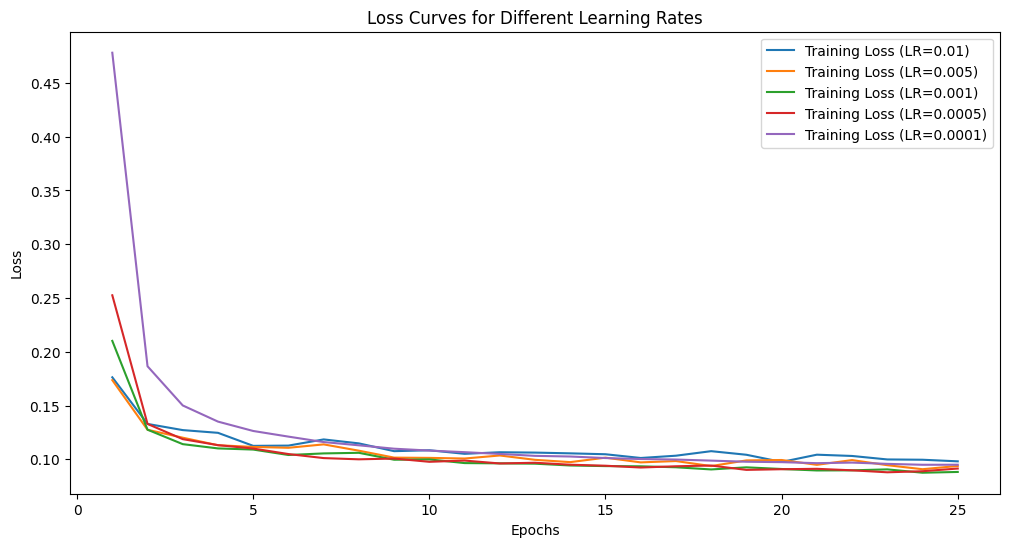

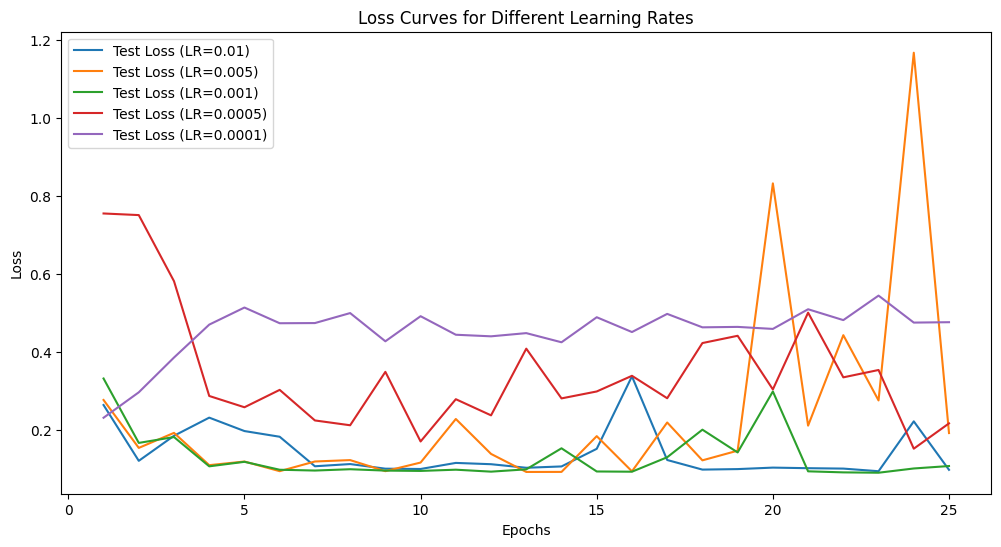

In [ ]:
plt.figure(figsize=(12, 6))
num_epochs = 25
epochs_range = range(1, num_epochs +1)

for lr_val, history_data in learning_rates_histories.items():
    plt.plot(epochs_range, history_data["train_loss"], label=f"Training Loss (LR={lr_val})")
    #plt.plot(epochs_range, history_data["Loss"], label=f"Test Loss (LR={lr_val})")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curves for Different Learning Rates")
plt.legend()

plt.figure(figsize=(12, 6))
num_epochs = 25
epochs_range = range(1, num_epochs +1)

for lr_val, history_data in learning_rates_histories.items():
    #plt.plot(epochs_range, history_data["train_loss"], label=f"Training Loss (LR={lr_val})")
    plt.plot(epochs_range, history_data["Loss"], label=f"Test Loss (LR={lr_val})")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curves for Different Learning Rates")
plt.legend()

Observando estes gráficos, podemos notar algumas coisas. A funçao perda nos teste não apresentam uma queda com o aumento do numero de épocas em sua maioria, não entendi o porque que isso não aconteceu.

Somente a linha vermelha, **lr = 0.0005** que apresentou um comportamente esperado e também apresentou a **melhor acurácia**.

# Efeito da Regularização e métodos de Otimização

Definimos então as seguintes configurações:

*   [123,128,128]
*   batch_size = 128
*   Learning_rate = 0.0005
*   Epochs = 25



In [ ]:
fixed_hidden_layer_config = [128, 128,128]
batch_size = 128
learning_rate = 0.0005
num_epochs = 25

Vamos armazenar os resultados aqui:

In [ ]:
results_log = []

Vamos testar  Weight Decay (Reguralização L2)

In [ ]:
weight_decays_to_test = [0.0, 1e-5, 1e-4, 1e-3, 1e-2]
wd_results_accuracies = {}

for wd in weight_decays_to_test:
  print(f"Training weight decay: {wd}")
  model = DynamicStarClassifier(input_size, num_classes, fixed_hidden_layer_config)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=wd)

  config_name = f"WD_{wd}"
  train_loss, train_accuracy, test_accuracy = train_and_evaluate_batch_size(model, train_loader,criterion,optimizer, num_epochs)
  wd_results_accuracies[config_name] = (train_loss, train_accuracy, test_accuracy)
  results_log.append((config_name, train_loss, train_accuracy, test_accuracy))

  print(f'Test Accuracy: {test_accuracy:.4f}')

best_wd_config = max(wd_results_accuracies, key=lambda x: wd_results_accuracies[x][2])
print(f"Best Weight Decay Config: {best_wd_config}")


chosen_wd_for_opt_test = best_wd_config


Training weight decay: 0.0
Test Accuracy: 0.9708
Training weight decay: 1e-05
Test Accuracy: 0.9726
Training weight decay: 0.0001
Test Accuracy: 0.9710
Training weight decay: 0.001
Test Accuracy: 0.9611
Training weight decay: 0.01
Test Accuracy: 0.9559
Best Weight Decay Config: WD_1e-05


Vamos tambem testar diferentes Otimizadores:

In [ ]:
optimizers_config = {
    "Adam": optim.Adam,
    "SGD": optim.SGD,
    "RMSprop": optim.RMSprop
}

optimizers_results_accuracies = {}

for optimizer_name, optimizer_class in optimizers_config.items():
  print(f"Training optimizer: {optimizer_name}")

  model = DynamicStarClassifier(input_size, num_classes, fixed_hidden_layer_config)
  criterion = nn.CrossEntropyLoss()
  optimizer = optimizer_class(model.parameters(), lr=learning_rate)

  config_name = f"OPT_{optimizer_name}"
  train_loss, train_accuracy, test_accuracy = train_and_evaluate_batch_size(model, train_loader, criterion, optimizer, num_epochs)
  optimizers_results_accuracies[config_name] = (train_loss, train_accuracy, test_accuracy)
  results_log.append((config_name, train_loss, train_accuracy, test_accuracy))


  print(f'Test Accuracy: {test_accuracy:.4f}')

Training optimizer: Adam
Test Accuracy: 0.9714
Training optimizer: SGD
Test Accuracy: 0.7589
Training optimizer: RMSprop
Test Accuracy: 0.9686


Podemos Observar aqui pela acurácia, que o melhor otimizador foi o Adam, o qual ja estavamos usadno duraten todo o processo.

# Considerações Finais

Quando fui fazendo e rodando as partes fui obtendo certos resultados, que ja foram coemtados antes. Então pela acurácia, foi determinado as seguintes configurações para a rede neural:


*   batch_size = 128
*   [123,128,128]
*   Learning_Rate = 0.0005
*   Otimizador: Adam

Porém ao final fui executar todas as células e tive uma surpresa, algumas partes deram resultados diferente, apresentando taxas de acurácias diferntes.
Então isso me complicou um pouco pois a cada etapa eu usava a melhor configuração anterior. Ainda não sei como isso pode ser resolvido mas vamos aos seguintes resultados

Inicialemnte com uma arquitetura de 2 camdas ocultas, a primeira com 128 e a segunda com 64, com batch_size = 32 learning rate = 0.001. função perda = CrossEntropy e otimizado Adam. Tivemos uma acurácia de 97.23%

Depois, foi testado diferentes configurações de redes, isto é as profundidades e larguras da NN. Foram feitas 20 configurações diferetnes e a melhor foi a configuração com 3 camadas de 128 neurônios. Com acurácia de 97.33%


Agora foi variado a batch_size com 5 tamanhos diferentes e o melhor resultado foi com batch_size = 16 com 97.22% acurácia. (Anteriormente havia sido batch_size = 128 com 97,24% de acurácia)

Agora variando Leaning_Rate o melhor resultado foi a taxa de aprendizado = 0.0005 com uma acurácia de 97.23%. Sabemos que nessa parte não é so a acuracia que importa. Pois pode-se haver um caso de Overfittng para isso, foi plotado os gráfiscos da função erro. Na primeira vez o comportamente ficou bem legal, na segunda houve algumas variações que não sei o motivo.

Tambem foi testado meodos de regularização como o Weight Decay (regularização L2). E o melhor resultado foi sem a regularização.

Foi testado tabem outros otimizadores como o SGD e o RMSprop. O adam teve o melhor resultado.